In [1]:
import cv2

import random
import math

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo
from torch.utils.tensorboard import SummaryWriter

from IPython.display import Image

import time

from scipy import ndimage
from skimage import transform

from os import listdir
from os.path import isfile, join

loss_diagram = SummaryWriter()

In [2]:
#generating samples

def generate_points(center, radius, number):

    points = []

    for i in range(number):

        r = radius * math.sqrt(random.random())
        theta = random.uniform(0, 2 * math.pi)

        x = int(center[0] + r * math.cos(theta))
        y = int(center[1] + r * math.sin(theta))

        points.append((x, y))

    return points

def points_far_enough(points, min_distance):

    for i in range(len(points) - 1):
        for j in range(i + 1, len(points)):

            distance = math.hypot(points[i][0] - points[j][0], points[i][1] - points[j][1])

            if (distance < min_distance):
                return False
                
    return True

# https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html
def lum(color):
    return (0.299 * color[0] + 0.587 * color[1] + 0.114 * color[2])

def generate_shape_color(bg_color, number, luminance_difference):

    # luminance_difference = 20 # 100
    checking_prev_colors = 4
    
    colors = []

    color_generated = True

    while True:

        new_color = tuple(random.randint(0, 255) for i in range(3))

        #check if bg_color and new_color have sufficiently different luminances
        if (abs(lum(bg_color) - lum(new_color)) >= luminance_difference):

            #check if new color and every color in colors[] have sufficiently different luminances
            # this needs to be calculated based on neighboring colors, otherwise it cant find a suitable color

            if (len(colors) >= checking_prev_colors):

                if (abs(lum(colors[len(colors) - 1]) - lum(new_color)) < luminance_difference
                   or abs(lum(colors[len(colors) - 3]) - lum(new_color)) < luminance_difference):
                    color_generated = False
            
            else:
                for color in colors:
                    if (abs(lum(color) - lum(new_color)) < luminance_difference):
                        color_generated = False

            if (color_generated == False):
                color_generated = True
                continue
            
            colors.append(new_color)

        if (len(colors) == number):
            return colors

def add_noise(img):
    
    noise = np.random.normal(0, 6, img.shape).astype(np.float32)
    
    noisy_image = img.astype(np.float32) + cv2.GaussianBlur(noise, (7, 7), sigmaX=0)
    
    # Clip values to valid range [0, 255] and convert back to uint8
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    
    return noisy_image

def apply_h(img, points):
    
    height_half = len(img) // 2
    width_half = len(img[0]) // 2

    point_distance = 10

    x = random.randint(point_distance, width_half - point_distance)
    y = random.randint(point_distance, height_half - point_distance)

    rect = np.array([[x, y], [x + width_half, y], [x + width_half, y + height_half], [x, y + height_half]])
    
    #4 kotičke okna pomaknemo za naključne pomike v intervalu [-16, 16]
    
    rect_prim = np.array([[rect[0][0] + random.randint(-16, 16), rect[0][1] + random.randint(-16, 16)], 
                 [rect[1][0] + random.randint(-16, 16), rect[1][1] + random.randint(-16, 16)], 
                 [rect[2][0] + random.randint(-16, 16), rect[2][1] + random.randint(-16, 16)], 
                 [rect[3][0] + random.randint(-16, 16), rect[3][1] + random.randint(-16, 16)]], np.int32)

    shift = random.randint(0, 3)
    rect_prim = np.roll(rect_prim, shift, axis=-1)
    
    #iz 4 kotičkov in njihovih pomikov izračunamo homografijo H
    H, _ = cv2.findHomography(rect, rect_prim)

    H = np.linalg.inv(H)

    #inverz ocenjene homografije H^-1 apliciramo na sliko, dobimo transformirano sliko
    warped_image = cv2.warpPerspective(img, H, (img.shape[1], img.shape[0]), borderMode=cv2.BORDER_REPLICATE)
    
    #project points
    
    # Convert to numpy array in shape (H, W, 2)
    points = np.array(points)
    
    # Flatten to shape (H*W, 2)
    flat_points = points.reshape(-1, 2)
    
    # Add homogeneous coordinate (x, y) -> (x, y, 1)
    ones = np.ones((flat_points.shape[0], 1))
    points_homogeneous = np.hstack([flat_points, ones])  # shape (N, 3)

    # Apply homography
    projected = H @ points_homogeneous.T  # shape (3, N)
    projected = projected.T               # shape (N, 3)

    # Convert back to 2D
    transformed_points = projected[:, :2] / projected[:, 2:3]

    # Reshape to original shape (rows, cols, 2)
    transformed_array = transformed_points.reshape(points.shape)
    
    h_points_img = np.zeros(img.shape, dtype=np.uint8)

    if transformed_array.ndim == 2:
        for point in transformed_array:
            cv2.circle(h_points_img, (int(point[0]), int(point[1])), 0, 1, -1)
    else:
    
        for line in transformed_array:
            for point in line:
                cv2.circle(h_points_img, (int(point[0]), int(point[1])), 0, 1, -1)

    return warped_image, h_points_img 

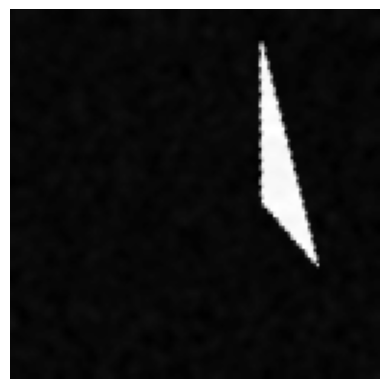

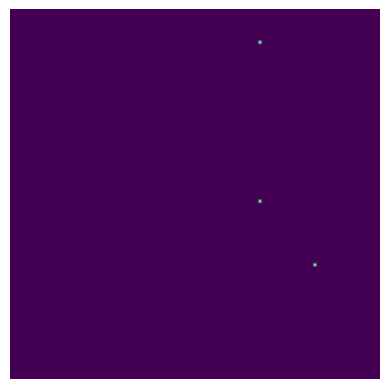

In [3]:
def generate_triangle(width, height):

    center = (width // 2, height // 2)
    radius = width // 2 - 5 #staying within bounds
    min_distance = 10

    while True:
        points = generate_points(center, radius, 3)
        
        if points_far_enough(points, min_distance):
            break

    background_color = tuple(random.randint(0, 255) for i in range(3))
    
    img = np.full((height, width, 3), background_color, dtype=np.uint8)

    pts_array = np.array([points], dtype=np.int32)
    cv2.fillPoly(img, pts_array, color=generate_shape_color(background_color, 1, 100)[0])

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    final_img, points_img = apply_h(img_gray, points)
    final_img = add_noise(final_img)

    # #build the points image
    # points_img = np.zeros(img.shape)
    
    # for point in points:
    #     cv2.circle(points_img, point, 1, (0, 255, 0), -1)

    return final_img, points_img

for i in range(1):
    image, points_image = generate_triangle(128, 128)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    
    plt.imshow(points_image)
    plt.axis('off')
    plt.show()

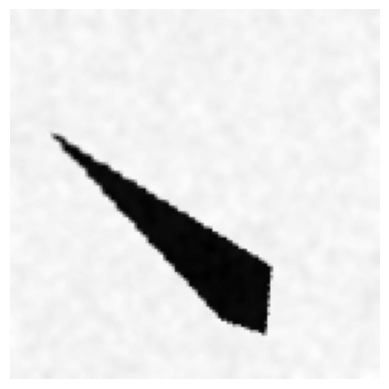

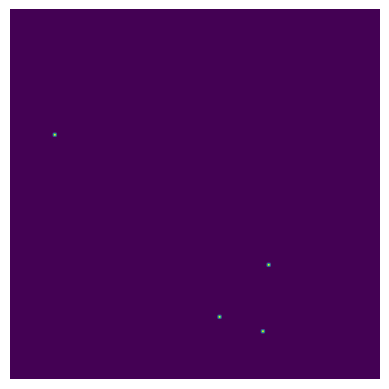

In [4]:
# https://stackoverflow.com/questions/9608148/python-script-to-determine-if-x-y-coordinates-are-colinear-getting-some-e
def colinear_points(points):
    # check if any 3 of the generated points are colinear (prevents generating triangle)
    
    for i in range(4):
        x1, y1 = points[i % 4]
        x2, y2 = points[(i + 1) % 4]
        x3, y3 = points[(i + 2) % 4]

        if (abs(((x1 * (y2 - y3)) + (x2 * (y3 - y1) + (x3 * (y1 - y2)))) / 2.0) < 1e-2):
            return True

    return False
    
# https://stackoverflow.com/questions/18583214/calculate-angle-of-triangle-python
def check_angles(points):
    # prevents square overlapping itself and colinearity

    angle_min = 10

    for i in range(4):
        x1, y1 = points[i % 4]
        x2, y2 = points[(i + 1) % 4]
        x3, y3 = points[(i + 2) % 4]

        dx1 = x1 - x2
        dy1 = y1 - y2

        dx2 = x3 - x2
        dy2 = y3 - y2

        numerator = dx1 * dx2 + dy1 * dy2
        denominator = math.sqrt((math.pow(dx1, 2) + math.pow(dy1, 2)) * (math.pow(dx2, 2) + math.pow(dy2, 2)))

        angle = abs(180 - math.degrees(math.acos(numerator / denominator)))

        if (angle < angle_min):
            return False

    return True

#https://stackoverflow.com/questions/3838329/how-can-i-check-if-two-segments-intersect
def ccw(p1, p2, p3):
    return (p3[1] - p1[1]) * (p2[0] - p1[0]) > (p2[1] - p1[1]) * (p3[0] - p1[0])

def is_valid_square(points):
    return ((ccw(points[0], points[1], points[3]) != ccw(points[2], points[1], points[3]) 
                 and ccw(points[0], points[2], points[1]) != ccw(points[0], points[2], points[3]))) 

def sort_by_angle(points, center):

    def angle(point):
        return math.atan2(point[1] - center[1], point[0] - center[0])

    return sorted(points, key=angle)


def generate_square(width, height):

    center = (width // 2, height // 2)
    radius = width // 2 - 5 #staying within bounds
    min_distance = 10

    while True:
        points = generate_points(center, radius, 4)
        points = sort_by_angle(points, center)
        
        if points_far_enough(points, min_distance) and is_valid_square(points) and check_angles(points) and not colinear_points(points):
            break

    background_color = tuple(random.randint(0, 255) for i in range(3))
    
    img = np.full((height, width, 3), background_color, dtype=np.uint8)

    pts_array = np.array([points], dtype=np.int32)
    cv2.fillPoly(img, pts_array, color=generate_shape_color(background_color, 1, 100)[0])

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    final_img, points_img = apply_h(img_gray, points)
    final_img = add_noise(final_img)

    # points_img = np.zeros(img.shape)
    
    # for point in points:
    #     cv2.circle(points_img, point, 1, (0, 255, 0), -1)

    return final_img, points_img

for i in range(1):
    image, points_image = generate_square(128, 128)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

    plt.imshow(points_image)
    plt.axis('off')
    plt.show()

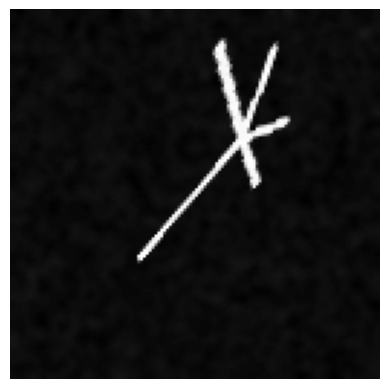

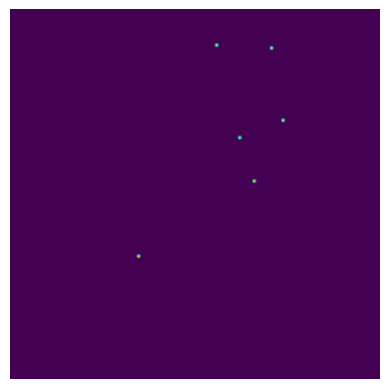

In [6]:
def check_angles_star(points, center_point):
    # prevents square overlapping itself and colinearity

    angle_min = 40
    
    for i in range(len(points) - 1):
        for j in range(i + 1, len(points)):
            x1, y1 = points[i]
            x2, y2 = points[j]
            x3, y3 = center_point
    
            dx1 = x1 - x2
            dy1 = y1 - y2
    
            dx2 = x3 - x2
            dy2 = y3 - y2
    
            numerator = dx1 * dx2 + dy1 * dy2
            denominator = math.sqrt((math.pow(dx1, 2) + math.pow(dy1, 2)) * (math.pow(dx2, 2) + math.pow(dy2, 2)))
    
            if (denominator == 0):
                return False
            
            angle = abs(180 - math.degrees(math.acos(numerator / denominator)))
    
            if (angle < angle_min):
                return False

    return True


def generate_star(width, height):

    center = (width // 2, height // 2)
    radius = width // 2 - 30
    min_distance = 15

    center_point = generate_points(center, radius, 1)
    
    while True:
        points = generate_points(center, radius, 5)
        
        if check_angles_star(points, center_point[0]):
            
            points.append(center_point[0])
            if points_far_enough(points, min_distance):
                break

    background_color = tuple(random.randint(0, 255) for i in range(3))
    
    img = np.full((height, width, 3), background_color, dtype=np.uint8)

    pts_array = np.array(points, dtype=np.int32)

    color = generate_shape_color(background_color, 1, 100)[0]
    
    for i in range(len(pts_array) - 1):
        cv2.line(img, pts_array[i], pts_array[len(pts_array) - 1], color=color, thickness=2)

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    final_img, points_img = apply_h(img_gray, points)
    final_img = add_noise(final_img)
    
    # points_img = np.zeros(img.shape)
    
    # for point in points:
    #     cv2.circle(points_img, point, 1, (0, 255, 0), -1)

    return final_img, points_img


for i in range(1):
    image, points_image = generate_star(128, 128)
    
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

    plt.imshow(points_image)
    plt.axis('off')
    plt.show()

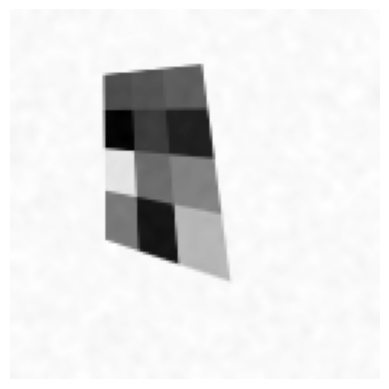

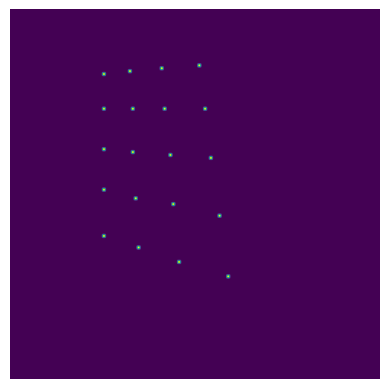

In [7]:
def generate_chessboard(width, height):
    rows = 3
    columns = 4

    square_dimension = width // 8
    
    center = (width // 2, height // 2)
    # radius = width // 2 - (square_dimension * rows // 2)
    radius = width // 2
    min_distance = 10

    while True:
    
        points = generate_points(center, radius, 1)

        if ((points[0][0] + (rows * square_dimension)) < width 
            and (points[0][1] + (columns * square_dimension)) < height):
            break
            
    matrix = [[points[0]]]

    for i in range(rows + 1):

        if (i > 0):
            matrix.append([(int(matrix[i - 1][0][0] + square_dimension), matrix[i - 1][0][1])])
        
        for j in range(1, columns + 1):

            matrix[i].append((matrix[i][j - 1][0], int(matrix[i][j - 1][1] + square_dimension)))
    
    background_color = tuple(random.randint(0, 255) for i in range(3))
    colors = generate_shape_color(background_color, rows * columns, 25)
    color_counter = 0
    
    img = np.full((height, width, 3), background_color, dtype=np.uint8)

    pts_array = []
    
    for i in range(len(matrix) - 1):

        for j in range(len(matrix[i]) - 1):
            
            pts_array.append(matrix[i][j])
            pts_array.append(matrix[i][j + 1])
            pts_array.append(matrix[i + 1][j + 1])
            pts_array.append(matrix[i + 1][j])

            cv2.fillPoly(img, np.array([pts_array]), color=colors[color_counter])
            color_counter += 1
            pts_array = []


    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    final_img, points_img = apply_h(img_gray, matrix)
    final_img = add_noise(final_img)

    #build the points image
    # points_img = np.zeros(img.shape)
    
    # for line in matrix:
    #     for point in line:
    #         cv2.circle(points_img, point, 1, (0, 255, 0), -1)

    return final_img, points_img

for i in range(1):
    image, points_image = generate_chessboard(128, 128)
        
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    
    plt.imshow(points_image)
    plt.axis('off')
    plt.show()

In [8]:
class ResnetBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1,  bias=False)
        self.conv3 = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

    def forward(self, x):
        
        output = self.conv1(x)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.conv2(output)
        output = self.bn2(output)

        if (self.in_channels != self.out_channels):
            
            tmp = self.conv3(x)
            output += tmp

        output = self.relu2(output)
                            
        return output


class Encoder(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.resnet1 = ResnetBlock(1, 64)
        self.resnet2 = ResnetBlock(64, 64)
        self.resnet3 = ResnetBlock(64, 64)
        self.resnet4 = ResnetBlock(64, 64)
        self.resnet5 = ResnetBlock(64, 128)
        self.resnet6 = ResnetBlock(128, 128)
        self.resnet7 = ResnetBlock(128, 128)
        self.resnet8 = ResnetBlock(128, 128)

        self.mp1 = nn.MaxPool2d(2, stride=2)
        self.mp2 = nn.MaxPool2d(2, stride=2)
        self.mp3 = nn.MaxPool2d(2, stride=2)
        self.mp4 = nn.MaxPool2d(2, stride=2)


    def forward(self, x):

        output = self.resnet1(x)
        output = self.resnet2(output)
        output = self.mp1(output)
        output = self.resnet3(output)
        output = self.resnet4(output)
        output = self.mp2(output)
        output = self.resnet5(output)
        output = self.resnet6(output)
        output = self.mp3(output)
        output = self.resnet7(output)
        output = self.resnet8(output)

        return output

class Decoder(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(256, 65, 1, bias=False) 

        self.bn1 = nn.BatchNorm2d(256)

        self.relu1 = nn.ReLU()

    def forward(self, x):

        output = self.conv1(x)
        output = self.bn1(output)
        
        output = self.relu1(output)
        
        output = self.conv2(output)

        return output

class Network(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.enc = Encoder()
        self.dec = Decoder()

    def forward(self, x):

        output = self.enc(x)
        output = self.dec(output)

        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Network().to(device)
torchinfo.summary(model, input_size=(1,1,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
Network                                  [1, 65, 32, 32]           --
├─Encoder: 1-1                           [1, 128, 32, 32]          --
│    └─ResnetBlock: 2-1                  [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-1                  [1, 64, 256, 256]         576
│    │    └─BatchNorm2d: 3-2             [1, 64, 256, 256]         128
│    │    └─ReLU: 3-3                    [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-4                  [1, 64, 256, 256]         36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 256, 256]         128
│    │    └─Conv2d: 3-6                  [1, 64, 256, 256]         64
│    │    └─ReLU: 3-7                    [1, 64, 256, 256]         --
│    └─ResnetBlock: 2-2                  [1, 64, 256, 256]         4,096
│    │    └─Conv2d: 3-8                  [1, 64, 256, 256]         36,864
│    │    └─BatchNorm2d: 3-9             [1, 64, 256, 256]         128


In [17]:
#priprava ucnih primerov
def generate_batch(batch_size, width, height, device):

    images = []
    point_images = []
    
    for i in range(batch_size):

        #0 -> triangle; 1 -> square; 2 -> star; 3 -> checkerboard
        rand_img = random.randint(0, 3)

        if (rand_img == 0):
            img, points_img = generate_triangle(width, height)
        elif (rand_img == 1):
            img, points_img = generate_square(width, height)
        elif (rand_img == 2):
            img, points_img = generate_star(width, height)
        elif (rand_img == 3):
            img, points_img = generate_chessboard(width, height)

        img = torch.tensor(img).to(device).unsqueeze(0).to(torch.float32)
        points_img = torch.tensor(points_img).to(device).unsqueeze(0).to(torch.float32)

        #Reshape v velikost H/8, 8, W/8, 8
        points_img = torch.reshape(points_img, (height // 8, 8, width // 8, 8))
        
        #Permute kanalov v vrstni red H/8, W/8, 8, 8
        points_img = torch.permute(points_img, (0, 2, 1, 3))
        
        #Reshape v velikost H/8, W/8, 64
        points_img = torch.reshape(points_img, (height // 8, width // 8, 64))
        
        #Dodamo kanal 65
        points_img_new = torch.zeros((height // 8, width // 8, 1))
        points_img = torch.cat((points_img, points_img_new), 2)

        #Za vsak izmed H/8, 8, W/8 pikslov preverimo, da je nastavljena ena izmed 65 točk
        for j in range(0, len(points_img)):
            for k in range(0, len(points_img[0])):
                found_points = []

                for l in range(len(points_img[j][k])):
                    if (points_img[j][k][l] == 1):
                        found_points.append(l)

                if (len(found_points) == 0):
                   #kjer ni nastavljena nobena nastavimo kanal 65
                    points_img[j][k][64] = 1
                
                elif (len(found_points) > 1):
                    #kjer je nastavljenih več ohranimo eno naključno

                    keep_rand = random.randint(0, len(found_points) - 1)
                    
                    for l in range(len(found_points)):
                        if (keep_rand == l):
                            continue
                        
                        points_img[j][k][found_points[l]] = 0

        points_img = torch.permute(points_img, (2, 0, 1))

        images.append(img)
        point_images.append(points_img)
        
    return torch.stack(images), torch.stack(point_images)
# generate_batch(1, 256, 256, device)

In [ ]:
# import sys
# np.set_printoptions(threshold=sys.maxsize)

In [14]:
image, point_image = generate_batch(1, 128, 128, device)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Network().to(device)

iterations = 1 #1000
batch_size = 1
epochs = 100 #10

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 1e-3)

steps_train = 0
steps_val = 0

for epoch in range(epochs):

    train_loss = 0
    val_loss = 0

    start_time = 0
    
    #train

    model.train()

    for iteration in range(iterations):
        
        optimizer.zero_grad()
        
        outputs = model(image)
        loss = loss_function(outputs, point_image)
    
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()
        steps_train += 1

    print("Epoch done: ", str(epoch + 1), " (training). Loss: ", train_loss / iterations)

    #validate

    with torch.no_grad():
        model.eval()

        for iteration in range(iterations):
            
            outputs = model(image)
            loss = loss_function(outputs, point_image)
    
            val_loss += loss.item()
            steps_val += 1

    print("Epoch: ", str(epoch + 1), " (validating). Loss: ", val_loss / iterations)

Epoch done:  1  (training). Loss:  4.0841755867004395
Epoch:  1  (validating). Loss:  4.1583733558654785
Epoch done:  2  (training). Loss:  3.8184568881988525
Epoch:  2  (validating). Loss:  4.117103576660156
Epoch done:  3  (training). Loss:  3.5323801040649414
Epoch:  3  (validating). Loss:  4.054582118988037
Epoch done:  4  (training). Loss:  3.1867599487304688
Epoch:  4  (validating). Loss:  3.984454393386841
Epoch done:  5  (training). Loss:  2.8472490310668945
Epoch:  5  (validating). Loss:  3.9032199382781982
Epoch done:  6  (training). Loss:  2.554046869277954
Epoch:  6  (validating). Loss:  3.8493564128875732
Epoch done:  7  (training). Loss:  2.296175718307495
Epoch:  7  (validating). Loss:  3.7438199520111084
Epoch done:  8  (training). Loss:  2.0507984161376953
Epoch:  8  (validating). Loss:  3.5413694381713867
Epoch done:  9  (training). Loss:  1.8305491209030151
Epoch:  9  (validating). Loss:  3.2093992233276367
Epoch done:  10  (training). Loss:  1.6276065111160278
Epoch

In [12]:
def reshape_to_original_size(pred):

    #Reshape v velikost H/8, W/8, 8, 8
    pred = torch.permute(pred, (1, 2, 0)) # [16, 16, 65]
    pred = pred[:, :, :-1] # [16, 16, 64]
    pred = torch.reshape(pred, (pred.shape[0], pred.shape[1], 8, 8)) # [16, 16, 8, 8]

    #Permute kanalov v vrstni red H/8, 8, W/8, 8
    pred = torch.permute(pred, (0, 2, 1, 3)) # [16, 8, 16, 8]

    #Reshape v velikost H, W
    pred = torch.reshape(pred, (pred.shape[0] * 8, pred.shape[2] * 8)) # [128, 128]

    return pred

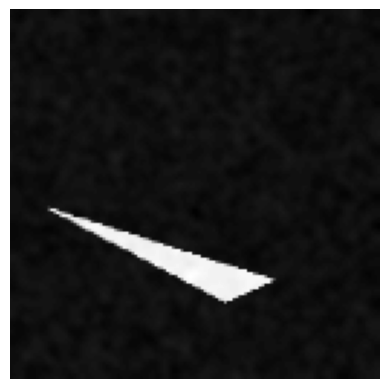

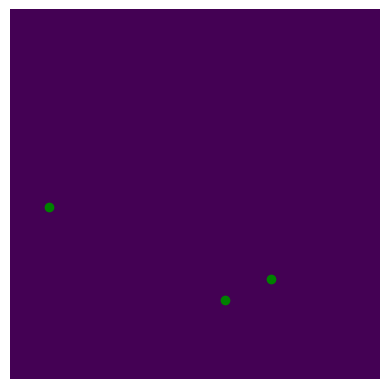

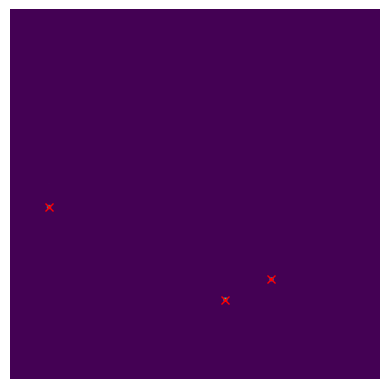

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# pretvori cilj
target = reshape_to_original_size(point_image[0])
py_tar, px_tar = np.where(target>0)

plt.imshow(image[0][0], cmap='gray')
plt.axis('off')
plt.show()

plt.plot(px_tar, py_tar, 'go', label='cilji')
plt.imshow(target)
plt.axis('off')
plt.show()

pred = model(image)
soft = nn.Softmax(0)
pred = soft(pred[0])
pred = reshape_to_original_size(pred)
pred = pred.detach().numpy()

# # najdi lokalne maksimume predikcije, vecje od minimalne vrednosti
local_max = (pred==ndimage.grey_dilation(pred, size=3))*pred>0.3
py_est, px_est = np.where(local_max)

plt.plot(px_est, py_est, 'rx', label='napovedi')
plt.imshow(pred)
plt.axis('off')
plt.show()

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Network().to(device)

iterations = 10
batch_size = 8
epochs = 1000

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 1e-3)

steps_train = 0
steps_val = 0

for epoch in range(epochs):

    train_loss = 0
    val_loss = 0

    start_time = 0
    
    #train

    model.train()

    for iteration in range(iterations):
        
        images, point_images = generate_batch(batch_size, 128, 128, device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_function(outputs, point_images)
    
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()
        loss_diagram.add_scalar("Loss/train/det", loss.item(), steps_train)
        steps_train += 1

    print("Epoch done: ", str(epoch + 1), " (training). Loss: ", train_loss / iterations)

    #validate

    with torch.no_grad():
        model.eval()

        for iteration in range(iterations):
        
            images, point_images = generate_batch(batch_size, 128, 128, device)
            
            outputs = model(images)
            loss = loss_function(outputs, point_images)
    
            val_loss += loss.item()
            loss_diagram.add_scalar("Loss/test/det", loss.item(), steps_val)
            steps_val += 1

    print("Epoch: ", str(epoch + 1), " (validating). Loss: ", val_loss / iterations)

    loss_diagram.flush()
    
torch.save(model, ("save_detection.pt"))

Epoch done:  1  (training). Loss:  3.004988598823547
Epoch:  1  (validating). Loss:  3.361141037940979
Epoch done:  2  (training). Loss:  1.1854448795318604
Epoch:  2  (validating). Loss:  1.0480110049247742
Epoch done:  3  (training). Loss:  0.46863395273685454
Epoch:  3  (validating). Loss:  0.5336500406265259
Epoch done:  4  (training). Loss:  0.29433100372552873
Epoch:  4  (validating). Loss:  0.2846026197075844
Epoch done:  5  (training). Loss:  0.24772001802921295
Epoch:  5  (validating). Loss:  0.2991391524672508
Epoch done:  6  (training). Loss:  0.2472882926464081
Epoch:  6  (validating). Loss:  0.24778223633766175
Epoch done:  7  (training). Loss:  0.23014751672744752
Epoch:  7  (validating). Loss:  0.22799151986837388
Epoch done:  8  (training). Loss:  0.24208882600069045
Epoch:  8  (validating). Loss:  0.21622908264398574
Epoch done:  9  (training). Loss:  0.24667733162641525
Epoch:  9  (validating). Loss:  0.2197430431842804
Epoch done:  10  (training). Loss:  0.2548818677

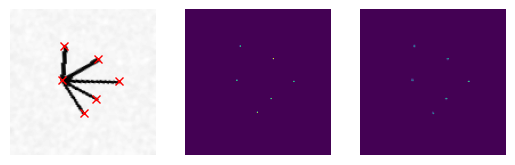

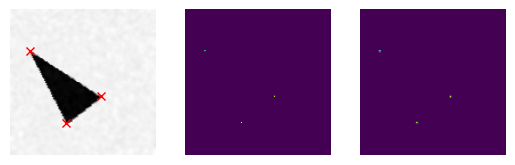

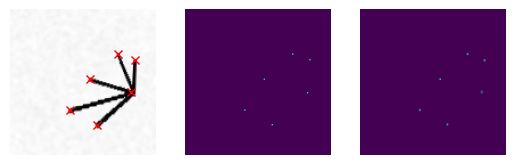

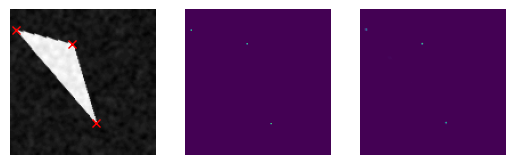

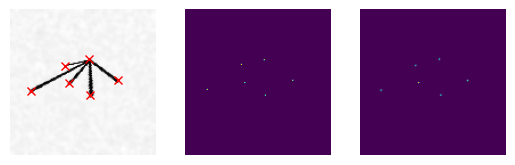

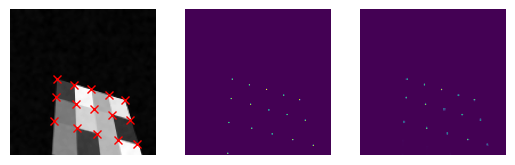

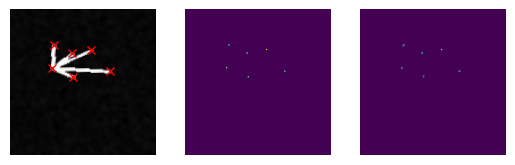

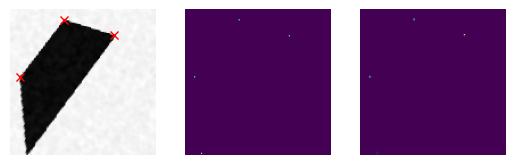

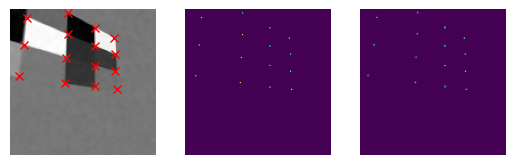

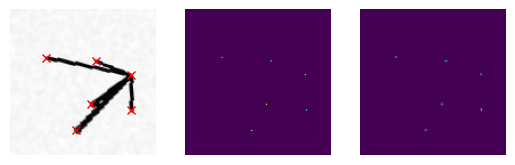

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load("save_detection.pt", device)

for i in range(10):

    image, point_image = generate_batch(1, 128, 128, device)
    
    # pretvori cilj
    target = reshape_to_original_size(point_image[0])
    # py_tar, px_tar = np.where(target>0)
    
    pred = model(image)
    soft = nn.Softmax(0)
    pred = soft(pred[0])
    pred = reshape_to_original_size(pred)
    pred = pred.detach().numpy()
    
    # najdi lokalne maksimume predikcije, vecje od minimalne vrednosti
    local_max = (pred==ndimage.grey_dilation(pred, size=3))*pred>0.2
    py_est, px_est = np.where(local_max)

    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(image[0][0], cmap='gray')
    ax[0].plot(px_est, py_est, 'rx', label='napovedi')
    ax[0].set_axis_off()
    ax[1].imshow(target)
    ax[1].set_axis_off()
    ax[2].imshow(pred)
    ax[2].set_axis_off()

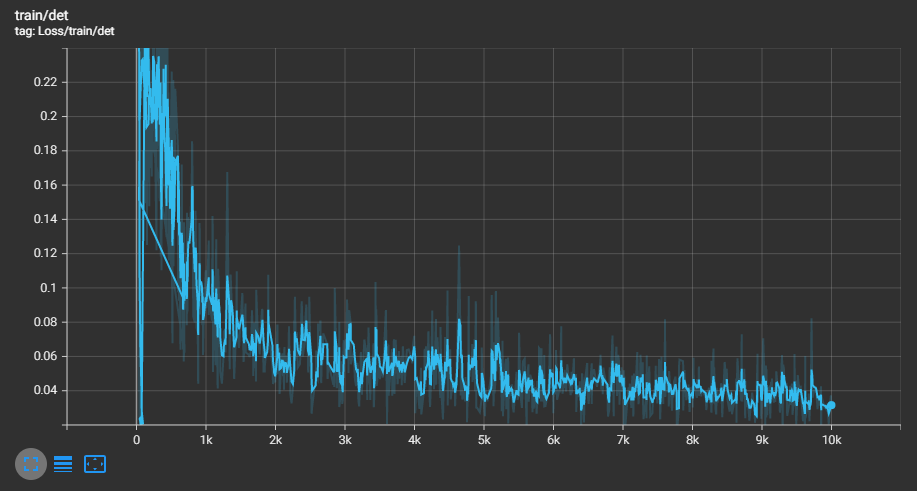

In [64]:
Image(filename='train_det.png')

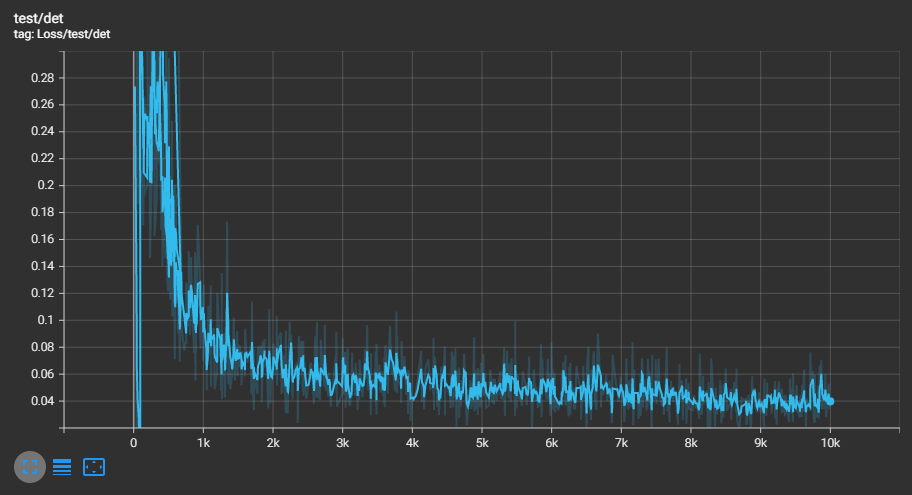

In [66]:
Image(filename='test_det.png')

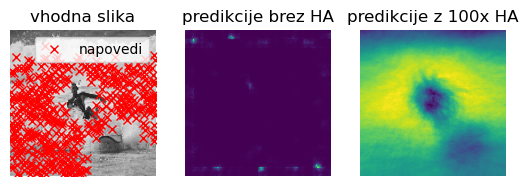

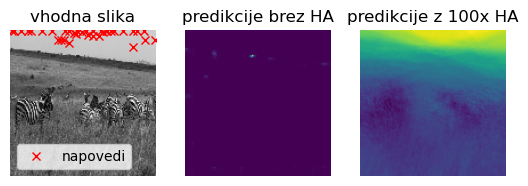

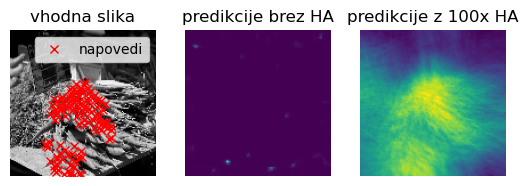

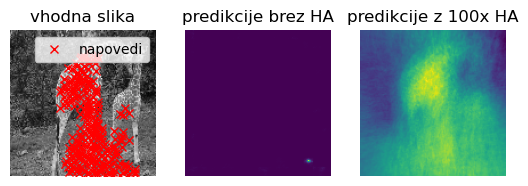

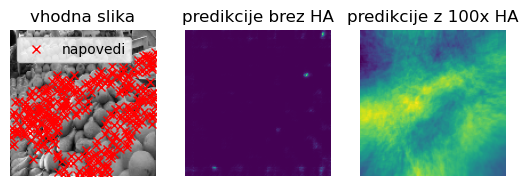

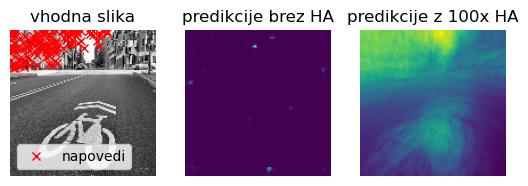

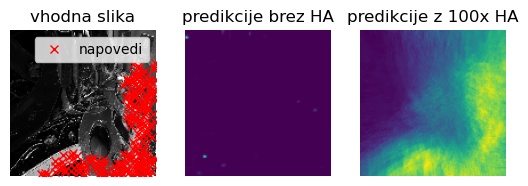

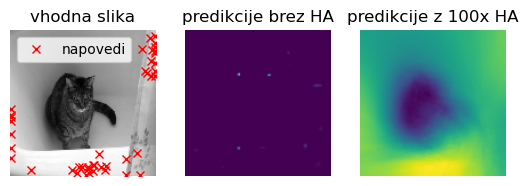

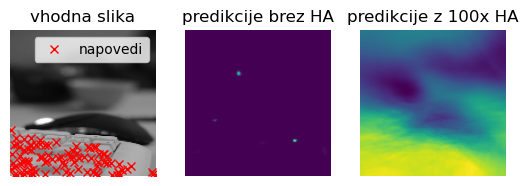

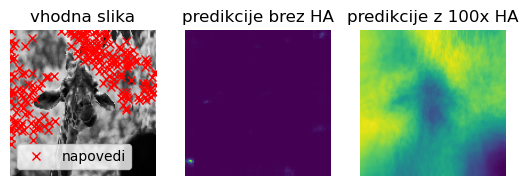

In [63]:
def apply_h_image(img):

    height_half = len(img) // 2
    width_half = len(img[0]) // 2

    point_distance = 10

    x = random.randint(point_distance, width_half - point_distance)
    y = random.randint(point_distance, height_half - point_distance)

    rect = np.array([[x, y], [x + width_half, y], [x + width_half, y + height_half], [x, y + height_half]])
    
    #4 kotičke okna pomaknemo za naključne pomike v intervalu [-16, 16]
    
    rect_prim = np.array([[rect[0][0] + random.randint(-16, 16), rect[0][1] + random.randint(-16, 16)], 
                 [rect[1][0] + random.randint(-16, 16), rect[1][1] + random.randint(-16, 16)], 
                 [rect[2][0] + random.randint(-16, 16), rect[2][1] + random.randint(-16, 16)], 
                 [rect[3][0] + random.randint(-16, 16), rect[3][1] + random.randint(-16, 16)]], np.int32)
    
    #iz 4 kotičkov in njihovih pomikov izračunamo homografijo H
    H, _ = cv2.findHomography(rect, rect_prim)

    H = np.linalg.inv(H)

    #inverz ocenjene homografije H^-1 apliciramo na sliko, dobimo transformirano sliko
    warped_image = cv2.warpPerspective(img, H, (img.shape[1], img.shape[0]), borderMode=cv2.BORDER_REPLICATE)

    return warped_image, H 

def inverse_h(pred, H):

    #inverz ocenjene homografije H^-1 apliciramo na sliko, dobimo transformirano sliko
    return cv2.warpPerspective(img, np.linalg.inv(H), (img.shape[1], img.shape[0]), borderMode=cv2.BORDER_REPLICATE)

model = torch.load("save_detection.pt", device)

path = "train"
files = [f for f in listdir(path) if isfile(join(path, f))]

for n in range(10):
    
    img = cv2.imread(join(path, files[random.randint(0, len(files) - 1)]))
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img_tensor = torch.tensor(img).to(device).unsqueeze(0).to(torch.float32)
        
    # prva detekcija, brez homografske adaptacije
    pred = model(torch.stack([img_tensor]))
    pred = soft(pred[0])
    pred = reshape_to_original_size(pred)
    pred = pred.detach().numpy()

    pred_cum = pred.copy()
    pred_no_ha = pred_cum.copy()
    
    for i in range(99):
        # ostale detekcije, vsaka z homografsko adaptacijo - naključno homografsko transformacijo
        
        # transformacija slike, pridobitev transformacijske matrike
        img_ha, H = apply_h_image(img)

        img_ha = torch.tensor(img_ha).to(device).unsqueeze(0).to(torch.float32)
        
        pred = model(torch.stack([img_ha]))
        pred = soft(pred[0])
        pred = reshape_to_original_size(pred)
        pred = pred.detach().numpy()

        # poravnava predikcije z originalno sliko
        pred_inv = inverse_h(pred, H)
        
        # akumulacija predikcij
        pred_cum += pred_inv
        
    # odstranimo morebitne nan vrednosti, normaliziramo
    pred = np.nan_to_num(pred_cum)
    pred /= pred.max()
    
    # najdi lokalne maksimume predikcije, vecje od rocno izbranega minimalnega pragu
    local_max = (pred==ndimage.grey_dilation(pred, size=3))*pred>0.8
    py_est, px_est = np.where(local_max)
    
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(img, cmap='gray')
    ax[0].plot(px_est, py_est, 'rx', label='napovedi')
    ax[0].set_axis_off()
    ax[0].set_title('vhodna slika')
    ax[0].legend()
    ax[1].imshow(pred_no_ha)
    ax[1].set_title('predikcije brez HA')
    ax[1].set_axis_off()
    ax[2].imshow(pred)
    ax[2].set_title('predikcije z 100x HA')
    ax[2].set_axis_off()